In [24]:
import numpy as np
import pandas as pd
import pickle

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

import umap
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from bertopic import BERTopic

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline


In [26]:
vector_files = {
    "TF-IDF": "../data/interim/tfidf_vectorized.pkl",
    "Word2Vec": "../data/interim/word2vec_vectorized.pkl",
    "BERT": "../data/interim/bert_vectorized.pkl",
}

vectorized_data = {}

for name, path in vector_files.items():
    with open(path, "rb") as f:
        data = pickle.load(f)
        if isinstance(data, list):
            data = np.array(data)
        vectorized_data[name] = data

df_reviews = pd.read_csv("../data/processed/processed_reviews.csv")

print(f"TF-IDF Shape: {vectorized_data['TF-IDF'].shape}")
print(f"Word2Vec Shape: {vectorized_data['Word2Vec'].shape}")
print(f"BERT Shape: {vectorized_data['BERT'].shape}")
print("\nSample Reviews:\n", df_reviews[["rating", "lemmatized_text"]].head())

TF-IDF Shape: (2560, 4455)
Word2Vec Shape: (2560, 100)
BERT Shape: (2560, 768)

Sample Reviews:
    rating                                    lemmatized_text
0       1  ['travel', 'lot', 'travel', 'often', 'last', '...
1       1  ['review', 'regard', 'flight', 'af', 'book', '...
2       1  ['recently', 'fly', 'air', 'france', 'flight',...
3       1  ['wow', 'horrible', 'experience', 'I', 've', '...
4       1  ['spend', 'fantastic', 'day', 'vacation', 'hon...


In [27]:
tfidf_corpus = [doc.split() for doc in df_reviews["lemmatized_text"]]
tfidf_dictionary = Dictionary(tfidf_corpus)
tfidf_bow = [tfidf_dictionary.doc2bow(doc) for doc in tfidf_corpus]

lda_model = LdaModel(
    corpus=tfidf_bow,
    id2word=tfidf_dictionary,
    num_topics=5,
    passes=15,
    random_state=42,
)

In [28]:
topics = lda_model.print_topics(num_words=10)

for topic in topics:
    print(topic)

# Create the directory if it doesn't exist
model_dir = "../models/lda_tfidf_model/"
os.makedirs(model_dir, exist_ok=True)

# Save the LDA model
lda_model.save(os.path.join(model_dir, "lda_tfidf_model"))

(0, '0.030*"\'seat\'," + 0.027*"\'flight\'," + 0.017*"\'good\'," + 0.016*"\'food\'," + 0.012*"\'service\'," + 0.012*"\'economy\'," + 0.010*"\'class\'," + 0.008*"\'well\'," + 0.008*"\'air\'," + 0.008*"\'france\',"')
(1, '0.038*"\'flight\'," + 0.022*"\'air\'," + 0.021*"\'france\'," + 0.015*"\'time\'," + 0.014*"\'service\'," + 0.012*"\'paris\'," + 0.011*"\'fly\'," + 0.010*"\'good\'," + 0.010*"\'food\'," + 0.008*"\'staff\',"')
(2, '0.029*"\'air\'," + 0.026*"\'france\'," + 0.022*"\'flight\'," + 0.015*"\'fly\'," + 0.012*"\'paris\'," + 0.009*"\'airline\'," + 0.009*"\'would\'," + 0.007*"\'time\'," + 0.006*"\'one\'," + 0.006*"\'luggage\',"')
(3, '0.020*"\'flight\'," + 0.017*"\'not\'," + 0.014*"\'we\'," + 0.014*"\'get\'," + 0.014*"\'air\'," + 0.014*"\'france\'," + 0.011*"\'do\'," + 0.010*"\'tell\'," + 0.009*"\'bag\'," + 0.009*"\'hour\',"')
(4, '0.010*"\'bag\'," + 0.009*"\'carry\'," + 0.008*"\'check\'," + 0.006*"\'weigh\'," + 0.006*"\'pay\'," + 0.006*"\'weight\'," + 0.004*"\'pleasant\']" + 0.003*

In [29]:
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=tfidf_corpus, dictionary=tfidf_dictionary, coherence="c_v"
)

coherence_lda = coherence_model_lda.get_coherence()
print(f"\nCoherence Score: {coherence_lda}")


Coherence Score: 0.35844857946063347


In [30]:
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, tfidf_bow, tfidf_dictionary)

pyLDAvis.display(lda_display)

In [31]:
num_topics = 5

# Fit NMF Model
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_topics = nmf_model.fit_transform(vectorized_data["TF-IDF"])

# Extract Feature Names Properly
tfidf_feature_names = vectorized_data["TF-IDF"].columns

# Store Top Words per Topic
top_words_per_topic = []

for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [tfidf_feature_names[i] for i in topic.argsort()[-10:]]  # Corrected
    top_words_per_topic.append(" | ".join(top_words))  # Join words with a separator

# Print Topics
for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {words}")


Topic 0: gate | arrive | connect | minute | time | airport | delay | paris | hour | flight
Topic 1: time | friendly | entertainment | crew | comfortable | great | flight | service | food | good
Topic 2: france flight | year | travel | airline | delta | fly air | fly | air france | france | air
Topic 3: af | leg | recline | premium economy | premium | economy | business class | business | class | seat
Topic 4: airline | baggage | customer service | tell | customer | check | day | lose | luggage | bag


In [32]:
pickle.dump(nmf_model, open("../models/nmf_tfidf_model/nmf_tfidf_model.pkl", "wb"))

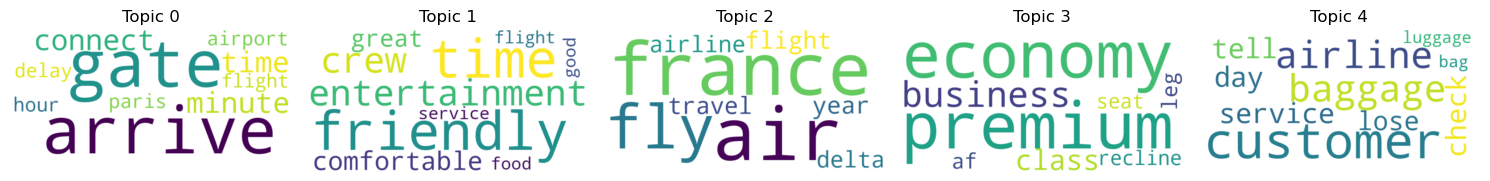

In [34]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure top words are correctly extracted
top_words_per_topic = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [
        tfidf_feature_names[i] for i in topic.argsort()[-10:]
    ]  # Get top words correctly
    top_words_per_topic.append(top_words)  # Store as a list of words

# Plot word clouds
fig, axes = plt.subplots(1, 5, figsize=(15, 8))  # Adjust layout
axes = axes.flatten()

for i, topic_words in enumerate(top_words_per_topic):
    wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
        " ".join(topic_words)
    )  # Properly join words

    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].set_title(f"Topic {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


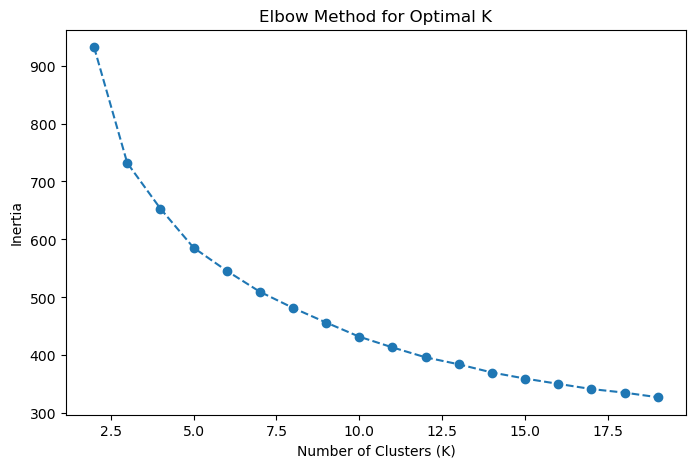

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try different values of K
num_clusters = list(range(2, 20))
inertia = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(vectorized_data["Word2Vec"])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(num_clusters, inertia, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


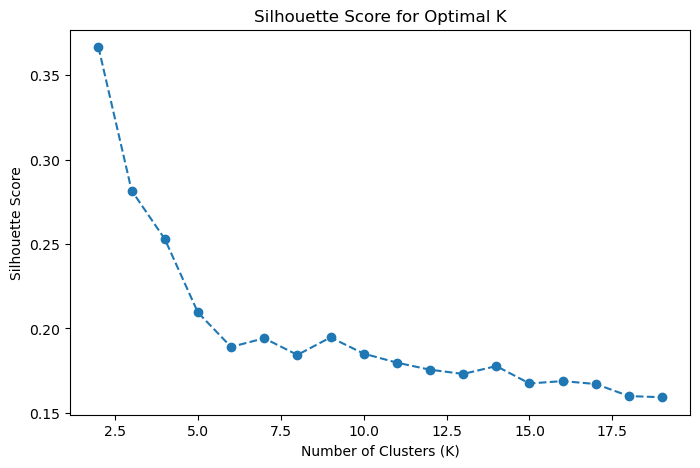

In [23]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(vectorized_data["Word2Vec"])
    score = silhouette_score(vectorized_data["Word2Vec"], labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(num_clusters, silhouette_scores, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal K")
plt.show()


AttributeError: 'list' object has no attribute 'shape'